# Project Title

**Authors:** Brandon Sienkiewicz, Ilan Haskel, Zach Cherna


## Overview

Insert overview

## Business Problem

Insert business problem

## Data Understanding

The provided data contains information on movies from various websites. These data sets include general information about the movies as well as more specific data such as rating, production cost, and total gross.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns

conn = sqlite3.connect('zippedData/im.db')
%matplotlib inline

In [2]:
bom_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
rtm_df = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep = "\t")
rtr_df = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep = "\t", encoding = 'latin1')
tmdb_df = pd.read_csv('zippedData/tmdb.movies.csv.gz')
tn_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
imbd_df = pd.read_sql("""
SELECT *
FROM movie_basics b
JOIN movie_ratings r
ON b.movie_id = r.movie_id
""", conn)

## Data Preparation and Modelling

### Data Preparation 1

### Data Modelling 1

### Data Preparation 2

### Data Modelling 2

### Data Preparation (Budget and Gross)
    
The following data sets were prepared to answer the questions, "Is there a relationship between production budget and rating?" and "Does production budget appear to affect the world-wide gross?". The majority of the following code is cleaning and merging The Numbers data set containing information about production costs and gross with the IMDB data set which contains information about movie ratings. These choices will help to make informed decisions on the primary focuses for future success.

#### Step 1 (Financial Data vs. Rating Data)
The first step is to create copies of the data frames, reformat the `release_date` to `year` (to match `start_year` in imbdu), and remove unwanted columns.

In [3]:
tnu_df = tn_df.copy()
imbdu_df = imbd_df.copy()

    #creating new dataframes to find matching movies in both dataframes
    
tnu_df['year'] = pd.DatetimeIndex(tnu_df['release_date']).year

    #converting the release date into year format
    
tnu_df = tnu_df.drop(columns = ['id','release_date'])
imbdu_df = imbdu_df.drop(columns = ['movie_id',
                                    'original_title',
                                    'movie_id',
                                    'genres'])

    #cleaning the dataframes to only have necessary columns

#### Step 2
Next, the movie names and year need to be combined for each dataframe to have an unique identifier between them.

In [4]:
tnu_df['unique'] = \
tnu_df['movie'].str.cat(tnu_df['year'].astype(str), sep = ' ')
imbdu_df['unique'] = \
imbdu_df['primary_title'].str.cat(imbdu_df['start_year'].astype(str), sep = ' ')

    #creating a new column in each df called unique which combines the
    #movie and the year. this is the first step in removing duplicate movies

#### Step 3
Now that the dataframes have matching identifiers, the movies in the data frame need to be matched.

In [5]:
tnu_df = tnu_df[tnu_df['unique'].isin(list(imbdu_df['unique']))]
imbdu_df = imbdu_df[imbdu_df['unique'].isin(tnu_df['unique'])]

    #checking the dfs against eachother and ending with only the movies that
    #are within both dfs

#### Step 4
The IMDB dataframe still has duplicate values as it draws from a much larger data set than the Numbers does. We will assume that the data in the Numbers corresponds to the most popular movies in the IMBD data set.

In [6]:
imbdu_df = imbdu_df.sort_values(by='numvotes', ascending=False)
imbdu_df = imbdu_df.drop_duplicates(subset='unique')

    #sorting by number of votes and dropping duplicates. given that tnu_df 
    #represents a smaller data set, it is very likely that the matching
    #movies from the imbdu data set would be the most popular

#### Step 5
Now that the duplicates are removed, we will do some final cleaning before merging the data sets.

In [7]:
imbdu_df = imbdu_df.drop(columns=['start_year', 'primary_title'])
tnu_df = tnu_df.drop(columns = ['movie', 'year'])

    #more data cleaning to prepare for a cleaned, merged table
    
cols = ['unique', 'production_budget',
        'domestic_gross', 'worldwide_gross']

     #rearranging the columns so that the unique film is first
    
tnu_df = tnu_df[cols]

#### Step 6
The data sets are cleaned and ready to merge.

In [8]:
df_analysis = pd.merge(tnu_df,imbdu_df)

    #merging the two tables into one

#### Step 7
Finally, the columns are rearraged and the final table is presented.

In [9]:
cols = ['unique', 'production_budget',
        'domestic_gross', 'worldwide_gross',
        'runtime_minutes', 'averagerating', 'numvotes']
df_analysis = df_analysis[cols]

    #rearranging the columns so that the unique film is first
    
df_analysis

,unique,production_budget,domestic_gross,worldwide_gross,runtime_minutes,averagerating,numvotes
0,Pirates of the Caribbean: On Stranger Tides 2011,"$410,600,000","$241,063,875","$1,045,663,875",136.0,6.6,447624
1,Dark Phoenix 2019,"$350,000,000","$42,762,350","$149,762,350",113.0,6.0,24451
2,Avengers: Age of Ultron 2015,"$330,600,000","$459,005,868","$1,403,013,963",141.0,7.3,665594
3,Avengers: Infinity War 2018,"$300,000,000","$678,815,482","$2,048,134,200",149.0,8.5,670926
4,Justice League 2017,"$300,000,000","$229,024,295","$655,945,209",120.0,6.5,329135
...,...,...,...,...,...,...,...
1457,Emily 2017,"$27,000","$3,547","$3,547",83.0,6.8,13
1458,Exeter 2015,"$25,000",$0,"$489,792",91.0,4.5,5156
1459,Dutch Kills 2015,"$25,000",$0,$0,90.0,5.1,82
1460,The Ridges 2011,"$17,300",$0,$0,89.0,2.9,127


#### Financial Data Comparison
The following cleaning is for a comparison of `production_budget` with the `domestic_gross` and `worldwide_gross`.

In [10]:
tnb_df = tn_df.copy()
tnb_df = tnb_df.drop(columns = ['release_date', 'id'])
    #cleaning df for prod budget vs. gross. using a
    #seperate df as this contains more values
tnb_df

,movie,production_budget,domestic_gross,worldwide_gross
0,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...
5777,Red 11,"$7,000",$0,$0
5778,Following,"$6,000","$48,482","$240,495"
5779,Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,A Plague So Pleasant,"$1,400",$0,$0


#### Formatting for Modelling
The following cell reformat the `production_budget`,`domestic_gross`, and `worldwide_gross` columns so that they can be used to model and analyse the data.

In [11]:
def clean(dataframe, column_name):

    #defining a function that removes $ and , and divides by 1.
    #million for clean models
    
    dataframe[column_name] = \
    dataframe[column_name].replace('[\$,]',
                                    '', regex=True).astype(float)
    dataframe[column_name] = dataframe[column_name]/1000000

    return dataframe

clean(df_analysis, 'production_budget')
clean(df_analysis, 'worldwide_gross')
clean(df_analysis, 'domestic_gross')
clean(tnb_df, 'production_budget')
clean(tnb_df, 'worldwide_gross')
clean(tnb_df, 'domestic_gross')
clean(df_analysis, 'numvotes');

#clean all necessary df/column combos for data modelling.

### Data Modelling (Budget and Gross)
The following cells look at the correlations and plots relating to the movie budgets and movie grosses to make informed recommendations.

In [12]:
df_analysis.corr()

,production_budget,domestic_gross,worldwide_gross,runtime_minutes,averagerating,numvotes
production_budget,1.000000,0.711554,0.785485,0.375025,0.226273,0.549558
domestic_gross,0.711554,1.000000,0.945085,0.318571,0.328727,0.668699
worldwide_gross,0.785485,0.945085,1.000000,0.329017,0.310343,0.656622
runtime_minutes,0.375025,0.318571,0.329017,1.000000,0.408142,0.428105
averagerating,0.226273,0.328727,0.310343,0.408142,1.000000,0.499399
numvotes,0.549558,0.668699,0.656622,0.428105,0.499399,1.000000


The above table shows the correlations between the variables in `df_analysis`. We will ignore the correlations between `production_budget` and `worldwide_gross`/`domestic_gross` as these will be explored within a larger data set. We will focus on `production_budget` vs. `averagerating`, `worldwide_gross` vs. `numvotes`, and `worldwide_gross` vs. `runtime_minutes`.

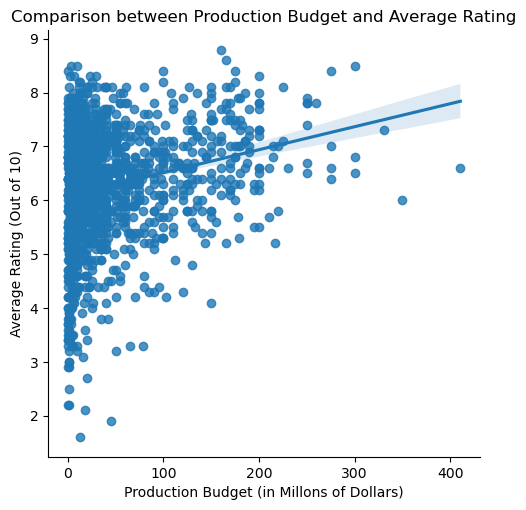

In [13]:
ax = sns.lmplot(x='production_budget', y='averagerating', data=df_analysis)
ax.set(xlabel='Production Budget (in Millons of Dollars)', 
       ylabel='Average Rating (Out of 10)', 
       title="Comparison between Production Budget and Average Rating");

As seen above, the correlation between `production_budget` and `averagerating` is 0.226273 which indicates a weak positive relationship; therefore, there does not appear to be a strong relationship between the two. Additionally, looking at the above graph does not indicate any other apparent patterns. Therefore, it does not appear that a higher production budget implies a better quality movie.

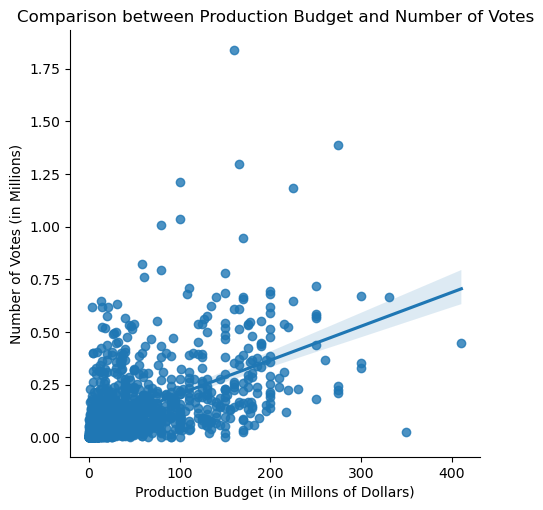

In [14]:
ax = sns.lmplot(x='production_budget', y='numvotes', data=df_analysis)
ax.set(xlabel='Production Budget (in Millons of Dollars)', 
       ylabel='Number of Votes (in Millions)', 
       title="Comparison between Production Budget and Number of Votes");

As seen above, the correlation between `production_budget` and `numvotes` is 0.549558 which indicates a moderate positive relationship, implying that there is some relationship between the two. There appears to be a large clumping of values in the lower left; however, this is to be expected as high budget and extremely popular movies are uncommon. Overall, it appears that a higher production budget impacts the popularity of the movie. Note: The popularity of the movie does not imply whether the movie is received well or not; but rather, that the movie receives a larger number of votes i.e. public attention.

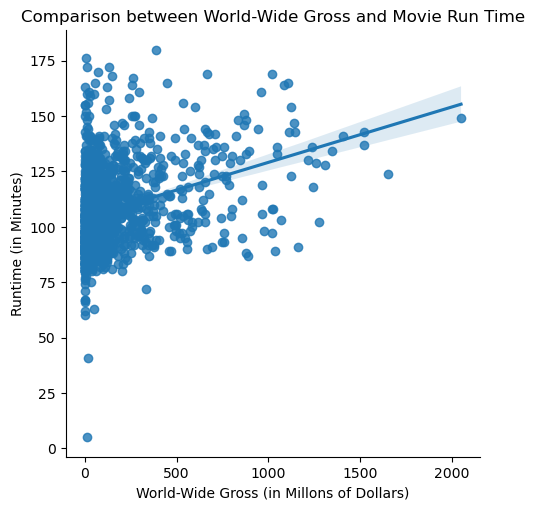

In [15]:
ax = sns.lmplot(x='worldwide_gross', y='runtime_minutes', data=df_analysis)
ax.set(xlabel='World-Wide Gross (in Millons of Dollars)', 
       ylabel='Runtime (in Minutes)', 
       title="Comparison between World-Wide Gross and Movie Run Time");

As seen above, the correlation between `worldwide_gross` and `runtime_minutes` is 0.329017 which indicates a weak positive relationship, implying that there is not a strong relationship between the two. An analysis of the graph does not show any other interesting patterns or relationship. We can conclude that the runtime does not affect the total gross of the movie.

In [16]:
tnb_df.corr()

,production_budget,domestic_gross,worldwide_gross
production_budget,1.000000,0.685682,0.748306
domestic_gross,0.685682,1.000000,0.938853
worldwide_gross,0.748306,0.938853,1.000000


The above table shows the correlations between the variables in `tnb_df`. We will examine the correlations between `production_budget` and `worldwide_gross`/`domestic_gross` with this larger data set. 

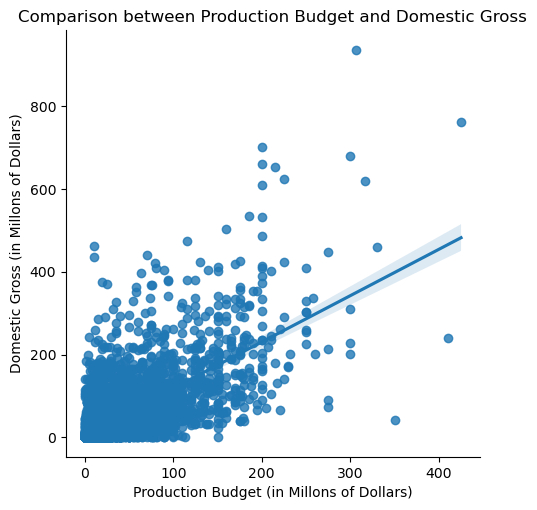

In [17]:
ax = sns.lmplot(x='production_budget', y='domestic_gross', data=tnb_df)
ax.set(xlabel='Production Budget (in Millons of Dollars)', 
       ylabel='Domestic Gross (in Millons of Dollars)', 
       title="Comparison between Production Budget and Domestic Gross");

As seen above, the correlation between `production_budget` and `domestic_gross` is 0.685682 which indicates a moderate-strong positive relationship, implying that the production budget has a positive impact on the domestic gross. It appears from the correlation and the graph that higher grossing movies will general generate a higher gross in a domestic market.

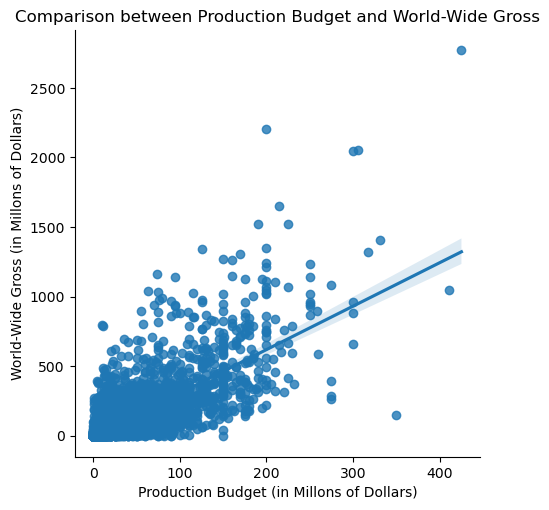

In [18]:
ax = sns.lmplot(x='production_budget', y='worldwide_gross', data=tnb_df)
ax.set(xlabel='Production Budget (in Millons of Dollars)', 
       ylabel='World-Wide Gross (in Millons of Dollars)', 
       title="Comparison between Production Budget and World-Wide Gross");

As seen above, the correlation between `production_budget` and `worldwide_gross` is 0.748306 which indicates a strong positive relationship, implying that the production budget has a positive impact on the world-wide gross. As mentioned in the previous graph analysis, it appears that production budget has a slightly stronger impact on the world-wide gross; therefore, marketing higher budget movies to a global market will generally yield a higher overall gross. This implies higher overall profits for the company.

## Evaluation

## Conclusion